engel_curve_estimation.py -- contact: Jay Sayre, jsayre@ucdavis.edu

Python code to replicate the nonlinear price index and welfare estimation procedure in Atkin, Faber, Fally and Gonzalez-Navarro (2023).

- Step 1: Estimate the engel curves, first by generating smoothed income for each market-period, and then by generating smoothed expenditures for each market-period-good
- Step 2: Estimate various measures of welfare
- Step 3: Generate plots for welfare measures

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d, CubicSpline
import matplotlib.pyplot as plt
from engel_curves import *

### Directories (change these to your own)
base_dir                       =  os.path.join(os.path.expanduser("~"),"Dropbox","Projects","Engel_Ado") 
data_dir                       =  os.path.join(base_dir,"data","source_data")
output_dir                     =  os.path.join(base_dir,"output")
temp_dir                       =  os.path.join(output_dir,"temp")
plot_dir                       =  os.path.join(output_dir,"plots")

### Inputs ###
cons_data                      =  os.path.join(data_dir,"basefile.dta")
price_data                     =  os.path.join(data_dir,"cleaned_prices.dta") ### For exact price correction
for_1stord_data                =  os.path.join(temp_dir,"fir_ord_data.dta") ### For first order approximation

### Intermediates ###
smth_x_shares_dta              =  os.path.join(temp_dir,"smoothexp_shares_python.dta")

### Outputs ###
price_indices_dta              =  os.path.join(output_dir,"price_indices_python.dta")

### Parameters ###
evaluation_points              =  100       ### Write 100 for 101 evaluation points (incl. zero), 1000 for 1001, etc.
bandwidth_portion              =  0.25
tails_extrapolation_percentage =  0.05
infinity_stata                 =  99999999  ### Stata doesn't like np.inf, so store as large-ish number
sigma                          =  0.7       ### Price elasticity (sigma=0.7 in AFFG baseline calibration)

winsorize                      =  True      ### If you want to winsorize large outlay values
extrapolate_tails              =  True      ### Whether to always extrapolate endpoints of tails
alternative_bandwidth_prcntile =  False     ### Alternative bandwidth/percentile measures
write_engelcurves              =  False     ### Whether to write Engel curves to intermediate file
read_engelcurves_frm_file      =  True     ### Whether to read Engel curves directly from intermediate file (if True, doesn't recompute)
compute_welfare                =  True      ### If false, only computes smoothed engel curves, not welfare measures
write_output                   =  False     ### Whether to write welfare output to file or not
write_stata                    =  False     ### Whether to write out to Stata or csv file (if False, writes to csv)
delete_neg_exp_shares          =  False     ### If there are any negative expenditure shares at ends of curve, extrapolate
weight_medians                 =  False     ### Whether to weight medians, which is pretty slow to run (this doesn't seem to work)
sarhan_correction              =  True      ### Whether to use uniformity assumption for missing medians
panel                          =  False     ### T/F for panel
round_to_decile                =  False     ### For plotting welfare, rounds percentiles to nearest decile
first_order_approx             =  False     ### First order approximation (not implented yet) (requires auxiliary data on prices)
exact_price_correction         =  False     ### Exact price correction (requires auxiliary data on prices)

### Variable names
market_id                      =  "market_id"
period_id                      =  "period_id"
good_id                        =  "i_good"
group_id                       =  "G_group"
period_0                       =  43
period_1                       =  55
### Code assumes hh_id is unique across markets but not necessarily periods. User MUST check this
hh_id                          =  "hh_id"
hh_wt                          =  "wt"
### outlays_var can be either a reference to a specific variable or generated from exp_var using "Gen"
outlays_var                    =  "exp_cap"
exp_var                        =  "expenditure"
percentile                     =  "percentile"   ### This var created in situ 
d_price_var                    =  "dp_prd1_prd0" ### Only used with exact_price_correction == True
type_extrap_tails              =  "linear"       ### can be linear, cubic, spline, first, second

In [2]:
### Read in data
df = pd.read_stata(cons_data)

### Save group-good matching
group_df   = df[[good_id, group_id]].drop_duplicates().reset_index(drop=True)
group_dict = dict(zip(group_df[good_id], group_df[group_id]))
mkt_gd_df  = df[[market_id,good_id]].drop_duplicates().sort_values([market_id,good_id]).reset_index(drop=True)

### Create evaluation point grid
eval_grid = np.arange(0,1.0+1/evaluation_points,step=1.0/evaluation_points)
eval_grid = np.array([np.round(a,15) for a in eval_grid])

if not read_engelcurves_frm_file:
    if outlays_var != "Gen":
        hh_exp_df = df.groupby([market_id,period_id,hh_id,hh_wt])[outlays_var].apply(np.mean).reset_index()
    else:
        hh_exp_df              = df.groupby([market_id,period_id,hh_id,hh_wt])[exp_var].sum().reset_index()
        hh_exp_df[outlays_var] = hh_exp_df[exp_var]
        hh_exp_df.drop(exp_var,axis=1,inplace=True)
        
    if winsorize:
        winsor_df = hh_exp_df.groupby([market_id,period_id])[outlays_var].apply(lambda x: stats.mstats.winsorize(x, limits=0.001)).reset_index()

        winsorized_list = []
        for a in list(winsor_df[outlays_var]):
            for b in a:
                winsorized_list.append(b)

        hh_exp_df[outlays_var] = winsorized_list
    ### Generate logged expenditure
    hh_exp_df['logexp_cap'] = np.log(hh_exp_df[outlays_var])

    ### Generate market by period dataframe
    mkt_prd_df                       = hh_exp_df.groupby([market_id,period_id])['logexp_cap'].max(min_count=0).reset_index()
    mkt_prd_df.rename(columns={'logexp_cap':'max_exp'},inplace=True)
    mkt_prd_df['min_exp']            = hh_exp_df.groupby([market_id,period_id])['logexp_cap'].min(min_count=0).reset_index()['logexp_cap']
    mkt_prd_df['wt_mkt_prd']         = hh_exp_df.groupby([market_id,period_id])[hh_wt].sum(min_count=0).reset_index()[hh_wt]
    hh_exp_df['rank']                = hh_exp_df.groupby([market_id,period_id])[outlays_var].rank(method='first')
    mkt_prd_df['num_households_mkt'] = hh_exp_df.groupby([market_id,period_id])[outlays_var].count().reset_index()[outlays_var]
    mkt_prd_df['uniq_obs_outlays']   = hh_exp_df.groupby([market_id,period_id])[outlays_var].nunique().reset_index()[outlays_var]

    hh_exp_df                        = hh_exp_df.merge(mkt_prd_df, on=[market_id,period_id], how='left')
    hh_exp_df.sort_values([market_id, period_id],inplace=True)
    hh_exp_df, mkt_prd_i             = create_identifier(hh_exp_df,[market_id,period_id],'mkt_prd',return_id_df=True)
    hh_exp_df['bandwidth_rng']       = (hh_exp_df['max_exp']-hh_exp_df['min_exp'])*bandwidth_portion

    ### Different ways to calculate which percentile a household falls into
    if alternative_bandwidth_prcntile:
        hh_exp_df['hh_prcnt_dist']   = (hh_exp_df['rank'].astype(float)-1)/(hh_exp_df['num_households_mkt']-1)
        hh_exp_df['bw_mpce']         = 1.0*(1/(hh_exp_df['num_households_mkt']-1))*(hh_exp_df['num_households_mkt']/hh_exp_df['uniq_obs_outlays'])**3.0
        hh_exp_df['bw_mpce']         = hh_exp_df.apply(lambda x: 1.0*(1/(evaluation_points-1))*(x['num_households_mkt']/x['uniq_obs_outlays'])**3.0 if evaluation_points/x['num_households_mkt'] > 1 else x['bw_mpce'], axis =1)
    else:
        hh_exp_df['hh_prcnt_dist']   = (hh_exp_df['rank'].astype(float)-0.5)/hh_exp_df['num_households_mkt']
        hh_exp_df['bw_mpce']         = (evaluation_points+1)/(100.0*(hh_exp_df['num_households_mkt']-1))
        
    ### Generate smoothed income for each market-period
    smoothed_inc = {}
    for i, mkt_prd in enumerate(mkt_prd_i['mkt_prd']):
        print("Running market-period:", mkt_prd)
        p = lpoly('hh_prcnt_dist', 'logexp_cap', eval_grid, 'bw_mpce', hh_exp_df[hh_exp_df['mkt_prd'] == mkt_prd], hh_wt)
        smoothed_inc[(mkt_prd_i.loc[i,market_id],mkt_prd_i.loc[i,period_id])] = p

    mkt_prd_good, good_cons_df = gen_good_cons_df(df=df, hh_exp_df=hh_exp_df, group_df=group_df, 
                                                hh_id=hh_id, period_id=period_id, market_id=market_id,
                                                good_id=good_id,exp_var=exp_var,outlays_var=outlays_var, 
                                                hh_wt=hh_wt, period_0=period_0, period_1=period_1,
                                                group_id = group_id)
    
    ### Generate smoothed expenditures for each market-period-good
    smoothed_exp = {}
    for i, mpg in enumerate(mkt_prd_good['mkt_prd_good']):
        print("Running market-period-good:", mpg)
        mkt = mkt_prd_good.loc[i,market_id]
        prd = mkt_prd_good.loc[i,period_id]
        gd  = mkt_prd_good.loc[i,good_id]
        tdf = good_cons_df[good_cons_df['mkt_prd_good'] == mpg]
        smoothed_exp[(mkt,prd,gd)] = lpoly('logexp_cap', 'exp_share_g', smoothed_inc[(mkt, prd)], 'bandwidth_rng', tdf, hh_wt)
    
    smoothed_df = good_cons_df[[market_id,period_id,good_id,group_id,'num_households_mkt','wt_mkt_prd']].drop_duplicates()

    smoothed_df = gen_comparision_df(smoothed_inc,smoothed_exp,smoothed_df,evl_grid=eval_grid, evl_points=evaluation_points,
                                    period_id=period_id, market_id=market_id, good_id=good_id, period_0=period_0, period_1=period_1,
                                    group_id=group_id)

    ### For writing Engel curves to intermediate file
    if write_engelcurves:      
        smoothed_df.to_stata(smth_x_shares_dta, write_index=False)

### Now compute welfare if requested
if compute_welfare:
    ### If reading Engel curves/smoothed income from intermediate file
    if read_engelcurves_frm_file:
        ### Read Engel curves from file 
        smoothed_df = pd.read_stata(smth_x_shares_dta)

        smoothed_inc, smoothed_exp = dataframe_to_dict(smoothed_df, period_id=period_id, market_id=market_id, good_id=good_id,
                                                                    period_0=period_0, period_1=period_1)
    
    if exact_price_correction:
        price_df = pd.read_stata(price_data)
        d_price_dict = dict(zip(list(zip(price_df[market_id],price_df[good_id])), price_df[d_price_var]))
        sum_price_grp = {}
        mkts_missing = []
        for key in smoothed_exp.keys():
            mkt, prd, gd = key
            sum_price_grp[(mkt, prd, group_dict[gd])] = 0
           
            if not (mkt,gd) in d_price_dict.keys(): #### 10/04/23: Is sample different??!?
                mkts_missing.append(mkt)
                ### 10/09/23: replace with NAN if missing
            else:
                if prd == period_0:
                    smoothed_exp[key]=smoothed_exp[key]*np.exp(-(sigma-1) * d_price_dict[mkt,gd])
                elif prd == period_1:
                    smoothed_exp[key]=smoothed_exp[key]*np.exp((sigma-1) * d_price_dict[mkt,gd])
                else: 
                    raise MorethanTwoPeriods
            sum_price_grp[(mkt, prd, group_dict[gd])] += smoothed_exp[key]
        for key in smoothed_exp.keys():
            mkt, prd, gd = key
            smoothed_exp[key] = smoothed_exp[key]/sum_price_grp[(mkt, prd, group_dict[gd])]
        mkts_missing = list(set(mkts_missing))
        print("Missing markets:", mkts_missing)
        
    print("checking monotonicity")
    monotonicity_dict = {}
    for key in smoothed_exp.keys():
        smoothed_exp[key] = monotonicity_tails(smoothed_exp[key], extrapolate_end=extrapolate_tails, 
                                                    evl_grid=eval_grid, evl_points=evaluation_points,
                                                    type_extrapolation=type_extrap_tails)

        if delete_neg_exp_shares:
            smoothed_exp[key] = replace_neg_exp_shares(smoothed_exp[key], evl_grid=eval_grid)
        monotonicity_dict[key] = monotonicity_check(smoothed_exp[key])

    print("identifying horizontal shifts")
    if panel:
        yh_df, p0_in_p1, p1_in_p0, use_curves, num_useable_goods_group = identify_horizontal_shifts_panel(smoothed_exp,
                                   smoothed_inc_dict=smoothed_inc, monotonicity_dict=monotonicity_dict,
                                   good_cons_df=good_cons_df,group_dict=group_dict, evl_points=evaluation_points,
                                   hh_id=hh_id, market_id=market_id, good_id=good_id, group_id=group_id, period_id=period_id, 
                                   period_0=period_0, period_1=period_1)
    else:
        yh0, yh1, p0_in_p1, p1_in_p0, use_curves, num_useable_goods_group = identify_horizontal_shifts(smoothed_exp,
                                   smoothed_inc_dict=smoothed_inc, monotonicity_dict=monotonicity_dict,
                                   mkt_gd_df=mkt_gd_df,group_dict=group_dict, evl_points=evaluation_points,
                                   market_id=market_id, good_id=good_id, period_0=period_0, period_1=period_1)
        
    print("welfare df")
    if panel:
        welfare_df = gen_welfare_df(smoothed_inc, smoothed_exp,smoothed_df=yh_df, 
                                yh0_dict={},yh1_dict={}, p0_in_p1_dict=p0_in_p1,
                                p1_in_p0_dict=p1_in_p0, use_curves_dict=use_curves,
                                num_gds_dict=num_useable_goods_group, 
                                monotonicity_dict=monotonicity_dict,
                                evl_grid=eval_grid, evl_points=evaluation_points,
                                hh_id=hh_id,market_id=market_id,good_id=good_id,group_id=group_id,
                                period_id=period_id,period_0=period_0, period_1=period_1, 
                                panel=panel)
    else:
        welfare_df = gen_welfare_df(smoothed_inc, smoothed_exp,smoothed_df=smoothed_df, 
                                yh0_dict=yh0,yh1_dict=yh1, p0_in_p1_dict=p0_in_p1,
                                p1_in_p0_dict=p1_in_p0, use_curves_dict=use_curves,
                                num_gds_dict=num_useable_goods_group, 
                                monotonicity_dict=monotonicity_dict,
                                evl_grid=eval_grid, evl_points=evaluation_points,
                                hh_id=hh_id,market_id=market_id,good_id=good_id,group_id=group_id,
                                period_id=period_id,period_0=period_0, period_1=period_1, 
                                panel=panel)

    print("p0 and p1")
    ### Construct P0 and P1
    if panel:
        engel_outlays_var0, engel_outlays_var1 = 'logexp_cap0', 'logexp_cap1'
        wts_prd0, wts_prd1 = hh_wt+'0', hh_wt+'1'
        groupby_vars = [market_id, hh_id]
    else:
        engel_outlays_var0, engel_outlays_var1 = 'log_smoothed_outlays0', 'log_smoothed_outlays1'
        wts_prd0, wts_prd1 = 'wt_mkt_prd0', 'wt_mkt_prd1'
        groupby_vars = [market_id, percentile]

    welfare_df['wt_mkt_prd']      = welfare_df[wts_prd0]+welfare_df[wts_prd1]
    welfare_df['logP0']           = welfare_df['yh1']-welfare_df[engel_outlays_var0]
    # welfare_df['logP0_nonmon']    = welfare_df['logP0']
    welfare_df['logP0']           = welfare_df.apply(lambda x: np.nan if x['use_curves'] == 0 else x['logP0'], axis=1)
    welfare_df['logP0_ranked']    = welfare_df['logP0']
    welfare_df['logP0']           = welfare_df['logP0'].apply(lambda x: np.nan if np.isinf(x) else x)

    welfare_df['logP1']           = welfare_df['yh0']-welfare_df[engel_outlays_var1]
    # welfare_df['logP1_nonmon']    = welfare_df['logP1']
    welfare_df['logP1']           = welfare_df.apply(lambda x: np.nan if x['use_curves'] == 0 else x['logP1'], axis=1)
    welfare_df['logP1_ranked']    = -1.0 * welfare_df['logP1']
    welfare_df['logP1']           = welfare_df['logP1'].apply(lambda x: np.nan if np.isinf(x) else x)
    welfare_df['logP1_neg']       = -1.0 * welfare_df['logP1']

    minmaxdf                      = welfare_df.groupby(groupby_vars)[['logP0','logP1_neg']].agg(['min','max']).reset_index()
    minmaxdf.columns              = groupby_vars+['minlogP0','maxlogP0','minlogP1','maxlogP1']
    welfare_df                    = welfare_df.merge(minmaxdf, on=groupby_vars, how='left')

    ### Identify noncrossing points and rank accordingly
    print("identify noncrossings")
    welfare_df['logP0_ranked'] = welfare_df.apply(identify_non_crossings, p0_or_p1='P0', axis=1)
    welfare_df['logP1_ranked'] = welfare_df.apply(identify_non_crossings, p0_or_p1='P1', axis=1)

    ### Compute first-order price correction here
    first_order_corr_p0 = 0
    first_order_corr_p1 = 0

    ### Take medians
    print("medians")
    grouped_medians_maxes         = welfare_df.groupby(groupby_vars)[['logP0_ranked','logP1_ranked']].median().reset_index()
    grouped_medians_maxes.columns = groupby_vars+['logP0_med','logP1_med']
    ### Weighted medians
    print("weighted medians")
    if weight_medians:
        wght_med_p0_df                = welfare_df.groupby(groupby_vars).apply(weighted_median, val='logP0_ranked', weight='wt_mkt_prd', dropna=True).reset_index()
        wght_med_p0_df.columns        = groupby_vars+['logP0_wmed']
        wght_med_p1_df                = welfare_df.groupby(groupby_vars).apply(weighted_median, val='logP1_ranked', weight='wt_mkt_prd', dropna=True).reset_index()
        wght_med_p1_df.columns        = groupby_vars+['logP1_wmed']
    ### Weighted means
    print("weighted means")
    wght_avg_df = welfare_df.groupby(groupby_vars).apply(lambda g: pd.Series({
        'logP0_wtmean':               nan_wght_average(g['logP0'],    weights=g['wt_mkt_prd']),
        'logP1_wtmean':               nan_wght_average(g['logP1_neg'],    weights=g['wt_mkt_prd']),
        })).reset_index()

    ### Merge various meds, means together
    grouped_medians_maxes         = grouped_medians_maxes.merge(minmaxdf, on=groupby_vars, how='outer')
    if weight_medians:
        grouped_medians_maxes         = grouped_medians_maxes.merge(wght_med_p0_df, on=groupby_vars, how='outer')
        grouped_medians_maxes         = grouped_medians_maxes.merge(wght_med_p1_df, on=groupby_vars, how='outer')
    grouped_medians_maxes         = grouped_medians_maxes.merge(wght_avg_df, on=groupby_vars, how='outer')

    ### Replace medians with NaNs if they are outside the min/max range
    grouped_medians_maxes['logP0_med']  = grouped_medians_maxes.apply(lambda x: np.nan if (x['logP0_med'] < x['minlogP0'] or x['logP0_med'] > x['maxlogP0']) else x['logP0_med'], axis = 1)
    grouped_medians_maxes['logP1_med']  = grouped_medians_maxes.apply(lambda x: np.nan if (x['logP1_med'] < x['minlogP1'] or x['logP1_med'] > x['maxlogP1']) else x['logP1_med'], axis = 1)
    if weight_medians:
        grouped_medians_maxes['logP0_wmed'] = grouped_medians_maxes.apply(lambda x: np.nan if (x['logP0_wmed'] < x['minlogP0'] or x['logP0_wmed'] > x['maxlogP0']) else x['logP0_wmed'], axis = 1)
        grouped_medians_maxes['logP1_wmed'] = grouped_medians_maxes.apply(lambda x: np.nan if (x['logP1_wmed'] < x['minlogP1'] or x['logP1_wmed'] > x['maxlogP1']) else x['logP1_wmed'], axis = 1)
    welfare_df   = welfare_df.merge(grouped_medians_maxes.drop(['minlogP0','maxlogP0','minlogP1','maxlogP1'], axis=1), on=groupby_vars, how='left')

    print("sarhan correction")
    ### perform sarhan correction
    if sarhan_correction:
        welfare_df['n_0']     = welfare_df['use_curves']
        welfare_df['n_1']     = welfare_df['use_curves']
        welfare_df['r1_0']    = welfare_df.apply(lambda x: 0 if x['logP0_ranked'] >= x['minlogP0'] else x['use_curves'],axis=1)
        welfare_df['r2_0']    = welfare_df.apply(lambda x: 0 if x['logP0_ranked'] <= x['maxlogP0'] else x['use_curves'],axis=1)
        welfare_df['r1_1']    = welfare_df.apply(lambda x: 0 if x['logP1_ranked'] >= x['minlogP1'] else x['use_curves'],axis=1)
        welfare_df['r2_1']    = welfare_df.apply(lambda x: 0 if x['logP1_ranked'] <= x['maxlogP1'] else x['use_curves'],axis=1)

        sarhan_df             = welfare_df.groupby(groupby_vars)[['n_0','n_1','r1_0','r2_0', 'r1_1','r2_1']].sum().reset_index()
        sarhan_df             = sarhan_df.merge(grouped_medians_maxes[groupby_vars+['minlogP0','maxlogP0','minlogP1','maxlogP1']], on=groupby_vars, how='left')
        sarhan_df['logPO_sc'] = (1/(2*(sarhan_df['n_0']-sarhan_df['r1_0']-sarhan_df['r2_0']-1)))*(((sarhan_df['n_0']-2*sarhan_df['r2_0']-1)*sarhan_df['minlogP0'])+((sarhan_df['n_0']-2*sarhan_df['r1_0']-1)*sarhan_df['maxlogP0']))
        sarhan_df['logP1_sc'] = (1/(2*(sarhan_df['n_1']-sarhan_df['r1_1']-sarhan_df['r2_1']-1)))*(((sarhan_df['n_1']-2*sarhan_df['r2_1']-1)*sarhan_df['minlogP1'])+((sarhan_df['n_1']-2*sarhan_df['r1_1']-1)*sarhan_df['maxlogP1']))
        welfare_df.drop(['n_0','n_1','r1_0','r2_0','r1_1','r2_1'],axis=1,inplace=True)

        welfare_df                 = welfare_df.merge(sarhan_df[groupby_vars+['logPO_sc','logP1_sc']], on=groupby_vars, how='left')
        welfare_df['logP0_med_sc'] = welfare_df.apply(lambda x: x['logPO_sc'] if np.isnan(x['logP0_med']) else x['logP0_med'],axis=1)
        welfare_df['logP1_med_sc'] = welfare_df.apply(lambda x: x['logP1_sc'] if np.isnan(x['logP1_med']) else x['logP1_med'],axis=1)
        if weight_medians:
            welfare_df['logP0_wmed_sc'] = welfare_df.apply(lambda x: x['logPO_sc'] if np.isnan(x['logP0_wmed']) else x['logP0_wmed'],axis=1)
            welfare_df['logP1_wmed_sc'] = welfare_df.apply(lambda x: x['logP1_sc'] if np.isnan(x['logP1_wmed']) else x['logP1_wmed'],axis=1)

    print("writing to file")
    if write_output:
        if write_stata:
            ### Write to stata dta
            welfare_df_stata        = welfare_df.copy()
            welfare_df_stata['yh0'] = welfare_df_stata['yh0'].apply(lambda x: infinity_stata if np.isposinf(x) else x)
            welfare_df_stata['yh0'] = welfare_df_stata['yh0'].apply(lambda x: -infinity_stata if np.isneginf(x) else x)
            welfare_df_stata['yh1'] = welfare_df_stata['yh1'].apply(lambda x: infinity_stata if np.isposinf(x) else x)
            welfare_df_stata['yh1'] = welfare_df_stata['yh1'].apply(lambda x: -infinity_stata if np.isneginf(x) else x)
            welfare_df_stata.to_stata(price_indices_dta, write_index=False)
        else:
            ### Write to csv 
            welfare_df.to_csv(price_indices_dta.replace(".dta",".csv"), index=False)
            

/home/j/Dropbox/Projects/Engel_Ado/ado/nonlinearEngelcurves/python_package/engel_curves.py:546: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop('mod_dec', axis=1, inplace=True)


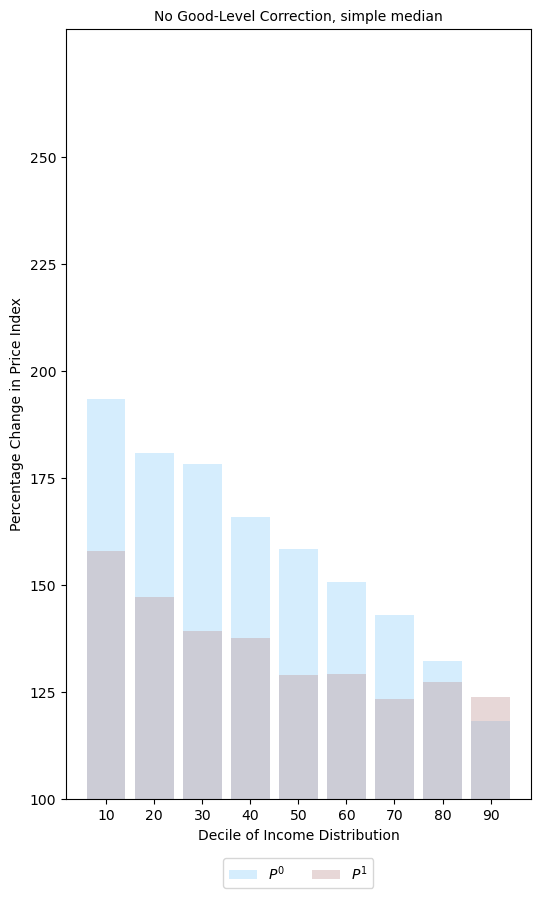

/home/j/Dropbox/Projects/Engel_Ado/ado/nonlinearEngelcurves/python_package/engel_curves.py:546: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop('mod_dec', axis=1, inplace=True)


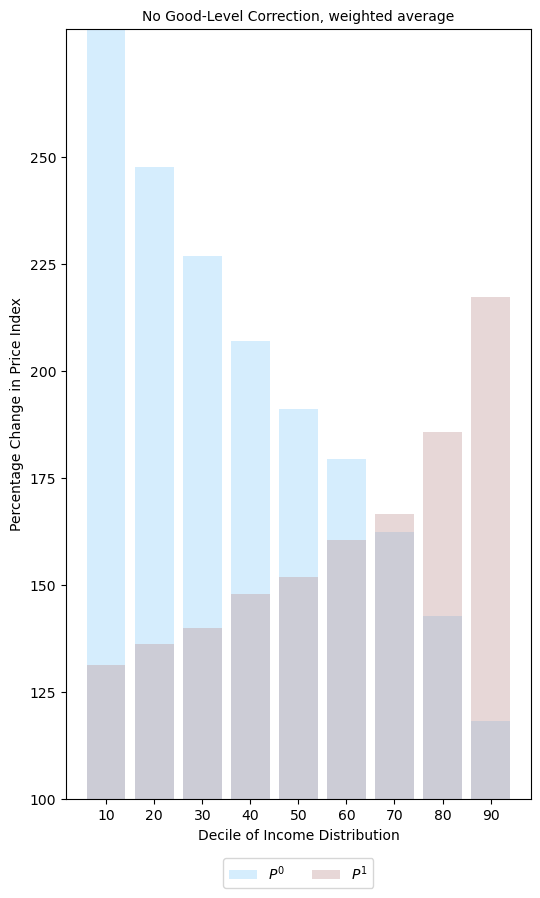

/home/j/Dropbox/Projects/Engel_Ado/ado/nonlinearEngelcurves/python_package/engel_curves.py:546: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.drop('mod_dec', axis=1, inplace=True)


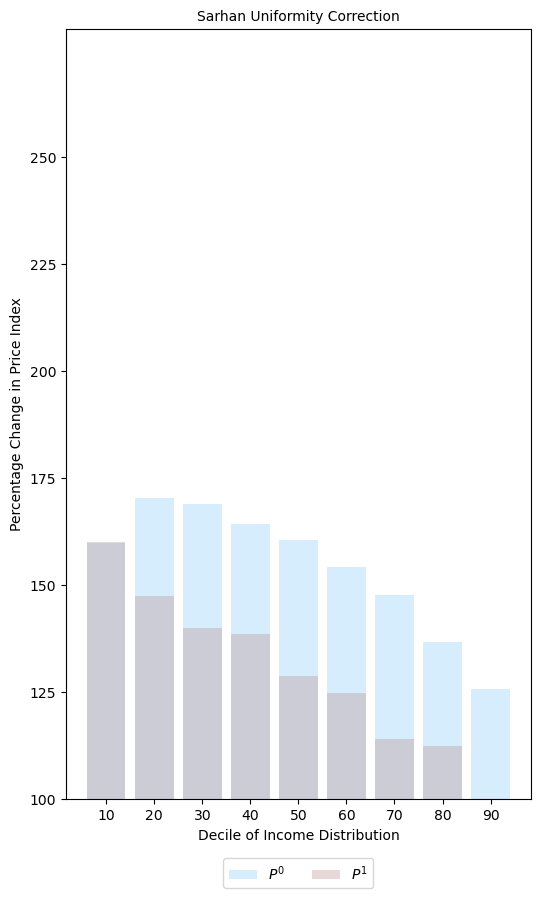

In [4]:
### Plot Engel curves
if panel:
    cols_0 = ['bandwidth_rng0','count0','exp_G0','exp_cap0','exp_share_g0','expenditure0','logexp_cap0','num_households_mkt0',
          'wt0','wt_mkt_prd0','yh1','p1_in_p0','use_curves','curve_mon1','num_useable_goods_group','mkt_good', 'percentile0',
          'logP0', 'logP0_ranked', 'minlogP0', 'maxlogP0', 'logP0_med', 'logP0_wmed', 
          'logP0_wtmean', 'logPO_sc', 'logP0_med_sc', 'logP0_wmed_sc']
    cols_1 = ['bandwidth_rng1', 'count1', 'exp_G1', 'exp_cap1', 'exp_share_g1', 'expenditure1', 'logexp_cap1', 'num_households_mkt1',
            'wt1', 'wt_mkt_prd1', 'yh0', 'p0_in_p1', 'use_curves', 'curve_mon0', 'num_useable_goods_group', 'mkt_good', 'percentile1', 
            'logP1',  'logP1_ranked',  'minlogP1',  'maxlogP1',  'logP1_med',  'logP1_wmed', 
            'logP1_wtmean',  'logPO_sc',  'logP1_med_sc',  'logP1_wmed_sc']

    # Separate the DataFrame based on periods:
    wel_df_0 = welfare_df[[hh_id, good_id, market_id, group_id] + cols_0].copy()
    wel_df_1 = welfare_df[[hh_id, good_id, market_id, group_id] + cols_1].copy()

    # Rename columns to drop the period suffix:
    wel_df_0.columns = [col[:-1] if ((col[-1:] in ["0","1"]) and (col[-2:-1] != 'P')) else col for col in wel_df_0.columns]
    wel_df_0.rename(columns={'yh':'yh1','p1_in_p':'p1_in_p0','wt_mkt_prd':'wt_mkt_prd0'},inplace=True)
    wel_df_1.columns = [col[:-1] if ((col[-1:] in ["0","1"]) and (col[-2:-1] != 'P')) else col for col in wel_df_1.columns]
    wel_df_1.rename(columns={'yh':'yh0','p0_in_p':'p0_in_p1','wt_mkt_prd':'wt_mkt_prd1'},inplace=True)

    # Add the period column:
    wel_df_0[period_id] = 0
    wel_df_1[period_id] = 1

    # Concatenate the dataframes for the two periods:
    welfare_plot_df = pd.concat([wel_df_0.reset_index(drop=True), wel_df_1.reset_index(drop=True)])
    welfare_plot_df['wt_mkt_prd'] = welfare_plot_df['wt_mkt_prd0'].fillna(0) + welfare_plot_df['wt_mkt_prd1'].fillna(0)
else:
    welfare_plot_df = welfare_df.copy()

if round_to_decile:
    welfare_plot_df['decile']   = (welfare_plot_df[percentile].round(1))*100
else:
    welfare_plot_df['decile']   = (welfare_plot_df[percentile].round(2))*100

if not sarhan_correction:
    welfare_plot_df['logP0_med_sc']      =  np.NaN
    welfare_plot_df['logP1_med_sc']      =  np.NaN
    if not weight_medians:
        welfare_plot_df['logP0_wmed_sc'] =  np.NaN
        welfare_plot_df['logP1_wmed_sc'] =  np.NaN
if not weight_medians:
    welfare_plot_df['logP0_wmed']        =  np.NaN
    welfare_plot_df['logP1_wmed']        =  np.NaN
    welfare_plot_df['logP0_wmed_sc']     =  np.NaN
    welfare_plot_df['logP1_wmed_sc']     =  np.NaN

welfare_plot_df = welfare_plot_df.groupby('decile').apply(lambda g: pd.Series({
    'logP0':               nan_wght_average(g['logP0_med'],    weights=g['wt_mkt_prd']),
    'logP1':               nan_wght_average(g['logP1_med'],    weights=g['wt_mkt_prd']),
    'logP0_sc':            nan_wght_average(g['logP0_med_sc'], weights=g['wt_mkt_prd']),
    'logP1_sc':            nan_wght_average(g['logP1_med_sc'], weights=g['wt_mkt_prd']),
    'logP0_wmed':          nan_wght_average(g['logP0_wmed'],   weights=g['wt_mkt_prd']),
    'logP1_wmed':          nan_wght_average(g['logP1_wmed'],   weights=g['wt_mkt_prd']),
    'logP0_wmed_sc':       nan_wght_average(g['logP0_wmed_sc'],weights=g['wt_mkt_prd']),
    'logP1_wmed_sc':       nan_wght_average(g['logP1_wmed_sc'],weights=g['wt_mkt_prd']),
    'logP0_wtmean':        nan_wght_average(g['logP0_wtmean'], weights=g['wt_mkt_prd']),
    'logP1_wtmean':        nan_wght_average(g['logP1_wtmean'], weights=g['wt_mkt_prd']),
})).reset_index()

log_variables = [
    "logP0","logP1","logP0_wtmean","logP1_wtmean"
]

if sarhan_correction and weight_medians:
    log_variables = log_variables + ["logP0_sc","logP1_sc","logP0_wmed","logP1_wmed","logP0_wmed_sc","logP1_wmed_sc"]
elif sarhan_correction and not weight_medians:
    log_variables = log_variables + ["logP0_sc","logP1_sc"]
elif not sarhan_correction and weight_medians:
    log_variables = log_variables + ["logP0_wmed","logP1_wmed"]

for log_var in log_variables:
    nonlogvar = log_var[3:]
    welfare_plot_df['pc_' + nonlogvar] = 100 * (np.exp(welfare_plot_df[log_var]) - 1) ### percent change

lastpart = ""
if exact_price_correction:
    lastpart = "_exact_price"

plot_bars(welfare_plot_df, 'pc_P1',        'pc_P0',         'No Good-Level Correction, simple median', filename=os.path.join(plot_dir, "wf_med_"+type_extrap_tails+"_myengels"+lastpart+".pdf"))
plot_bars(welfare_plot_df, 'pc_P1_wtmean',        'pc_P0_wtmean',         'No Good-Level Correction, weighted average', filename=os.path.join(plot_dir, "wf_wtmean_"+type_extrap_tails+"_myengels"+lastpart+".pdf"))
if sarhan_correction:
    plot_bars(welfare_plot_df, 'pc_P1_sc',         'pc_P0_sc',         'Sarhan Uniformity Correction', filename=os.path.join(plot_dir, "wf_sc_"+type_extrap_tails+"_myengels"+lastpart+".pdf"))
if weight_medians:
    plot_bars(welfare_plot_df, 'pc_P1_wmed',        'pc_P0_wmed',        'No Good-Level Correction, weighted median')
if sarhan_correction and weight_medians:
    plot_bars(welfare_plot_df, 'pc_P1_wmed_sc',        'pc_P0_wmed_sc',        'Sarhan Uniformity Correction, weighted median')

